In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy.io
import gc
import datetime
import time
import random
import matplotlib
import nbimporter
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _steady_state import a_steady
from _mbes import mbes, mbes_soc
from _do_calculation import solve_mbes
#matplotlib.pyplot.switch_backend('nbAgg')
#%qtconsole

Importing Jupyter notebook from _create_pdf.ipynb
Importing Jupyter notebook from _helper_functions.ipynb
Importing Jupyter notebook from _steady_state.ipynb
Importing Jupyter notebook from _mbes.ipynb
Importing Jupyter notebook from _do_calculation.ipynb


In [2]:
gcoll = 58.49348910584943
q = 1.39
quali =1000
fr = 3149;
kappa = np.pi*fr/quali #HWHM
delta = 0*2*np.pi #detuning cavity to spin central frequency ws-wc
deltac = 0*2*np.pi #detuning drive to cavity wc-wp
gperp = 2*np.pi*0.09 #HWHM
gpar = 2*np.pi*.001#0.001 #HWHM
gammaq = 125.66370614359172
nbins = 1701#701#5000#20
g_number = 1 #how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

9.892875266154258


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse

def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund
    
    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002)*(1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse

def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)
    
    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004)*(1-logistic.cdf(t, loc=tend-0.02, scale=0.004))
    
    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq


In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)

x_start = 5
x_stop = 20 #µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

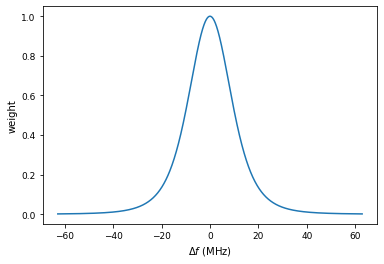

In [5]:
spins, gs, pdf = create_spins_inhomo_g(gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight');
#%qtconsole

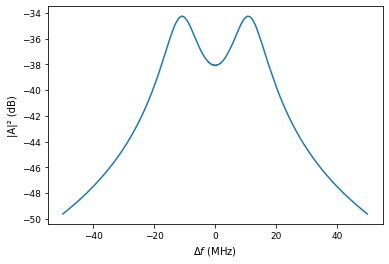

In [6]:
initsteady = (0.1,0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi,fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)');
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 200e-3#5*np.pi/gcoll
decaytime = 2000e-3
dt = 4e-3 #The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tlist = np.arange(0,pumptime+dt,dt)
tlistdecay = np.arange(0, decaytime+dt, dt)

# test time it takes to calculate


init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1::2] = 0

### Calibrate power

In [8]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-30, 0,0.5)
aref = 500

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, : ] = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack((np.real(asolpump[:,2::2]), np.real(asoldecay[:,2::2])))
    small[ctr, :, :] = np.vstack((np.real(asolpump[:,1::2]), np.real(asoldecay[:,1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

<ipython-input-9-0993edfcf8c6>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
<ipython-input-9-0993edfcf8c6>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolor(tplot, pin, szlos)


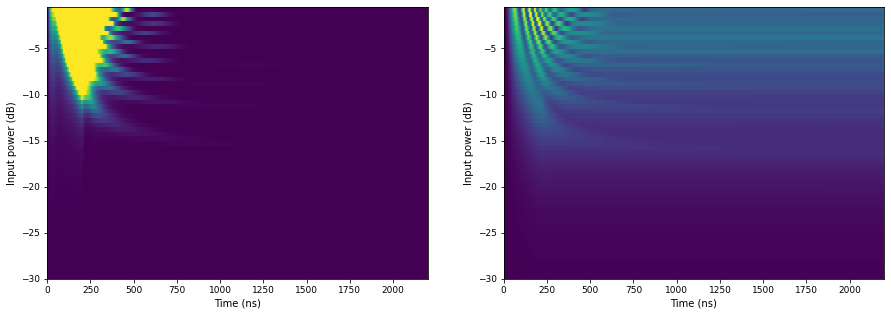

In [9]:
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.pcolor(tplot, pin, alos, vmin=0, vmax=60)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)');

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)');

### Linear Rabi oscillations

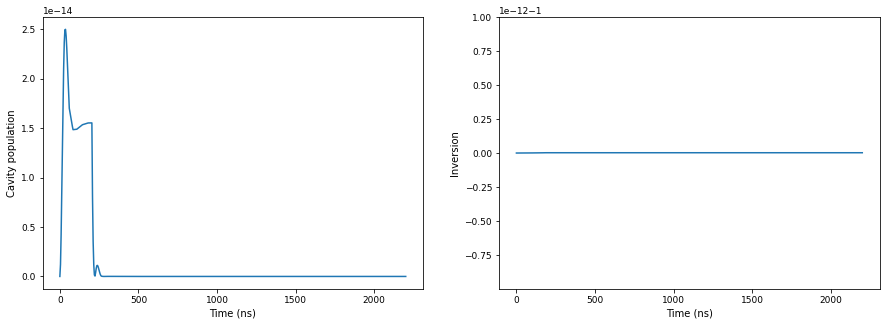

In [10]:
alos = np.zeros((len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))

asolpump, asoldecay, infodict = solve_mbes(mbes, init, pdf, tlist, tlistdecay, 0.00001, kappa, deltac, gs, gperp, spins, gpar)
alos = np.hstack((abs(asolpump[:,0])**2, abs(asoldecay[:,0])**2))
szlos = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
                  
                  
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(tplot, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Cavity population');

ax2.plot(tplot, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion');

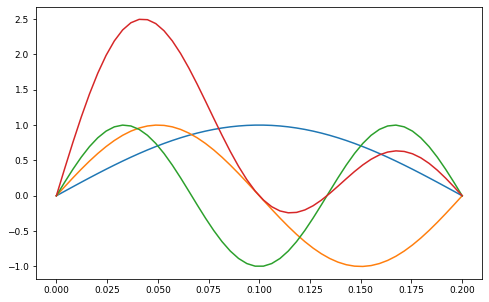

In [11]:
number_fcp = 3
ttest = np.linspace(0,pumptime,numsteps)
wgrund = np.pi/ttest[-1]
sumsin = np.zeros((number_fcp, len(ttest)))

fig, ax = plt.subplots(1,1, figsize=(8,5))

for i in range(number_fcp):
    sumsin[i, :] = np.sin(wgrund*ttest*(i+1))
    ax.plot(ttest, sumsin[i,:])
ax.plot(ttest, np.sum(sumsin, axis=0))
maxfourier = max(np.sum(sumsin, axis=0))

In [12]:
pumptime2 = 50e-3

class BasinHopping:
    
    def __init__(self):
        self.tp = np.arange(0,pumptime2+dt,dt)
        self.td = np.arange(0, decaytime+dt, dt)
        self.number_fcp = number_fcp
        self.min_pulse_length = 0.02
        self.max_ampl = aref*0.8
        self.max_t_ampl = aref
        self.target_time_decay = 1.9 #when after switching off the pulse the inversion should be maximum
        self.wgrund = np.pi/self.tp[-1]
        self.plot_handle = None
        self.max_time = 2 #maximum time pulse is allowed to last
        self.counter = 0
        self.solution = None
        self.fcomps = None
        self.idx = -1
        self.inversin_spectrum = None
        self.fitness = 0
        self.constant_on = True
        self.vars = []
        self.fig = None
        self.disp1 = display(Markdown(""), display_id='0')
        self.best_fitness = 1.
        self.scale_factor = 2*np.pi if self.number_fcp == 0 else 2*np.pi/self.number_fcp
        

        
    def main(self, initial=None):
        self.counter = 0
        t = datetime.datetime.now()
        self.filename_save = "/home/andreas/Physics/nelder_mead/basinhopping_%s"%t.strftime("%Y-%m-%d %H:%M:%S")
        filename_save = self.filename_save
        pumpt = pumptime
        if initial is None:
            if self.constant_on:
                init = np.random.uniform(0, self.scale_factor, self.number_fcp +2)
                init[-1] = 0.05*self.scale_factor
                init[-2] = 0.8*self.scale_factor
            else:
                init = np.random.uniform(-self.max_ampl, self.max_ampl, (self.number_fcp*2+1))
                self.scale_factor = 2*np.pi*self.max_ampl
                init[-1] = pumptime2*self.scale_factor
        else:
            if self.constant_on:
                init = initial
                init[-1] *= self.scale_factor
                init[-2] *= self.scale_factor
            else:
                init = initial
                self.scale_factor = 2*np.pi*self.max_ampl
                init[-1] *= self.scale_factor
        self.res = basinhopping(self.calculate_fitness, init, niter_success=15, T=0.02, stepsize=np.pi/4, disp=True, minimizer_kwargs= {'callback':self.plot_stuff, 'method': 'Nelder-Mead'}, accept_test=self.accept_test)
        return self.res
    
   
    def plot_stuff(self, fcomps):
        if not self.fig:
            self.fig, ((ax1, ax0), (ax2, ax3)) = plt.subplots(2,2,figsize=(15,10))
        else:
            ax1, ax0, ax2, ax3 = self.fig.axes
            ax1.clear()
            ax2.clear()
            ax3.clear()
            ax0.clear()
            gc.collect()
        pos1 = ax1.get_position()
        pos2 = ax2.get_position()
        pos3 = ax3.get_position()
        pos1n = [(pos2.x0+pos3.x0)/2, pos1.y0,  pos1.width, pos1.height] 
        
        
        ax1.plot(self.tp*1000, self.pulsei, 'b-')
        ax1.plot(self.tp*1000, self.pulseq, 'g-')
        
        szsol = np.real(np.sum(self.solution[:, 2::2], axis=1))
        asol = self.solution[:,0]
        
        ax1.plot(self.tp*1000, np.sqrt(self.pulsei**2+self.pulseq**2), 'k--')
        ax1.set_ylabel("Amplitude (a.u.)")
        ax1.set_xlabel("Time (ns)")        
        ax1.set_ylim([-self.max_t_ampl-50, self.max_t_ampl+50])
        ax1.set_xlim([-20, 20+self.tp[-1]*1000])
        ax2.plot(self.tp*1000, (szsol[:len(self.tp)]), 'r-')
        ax2.plot(self.td*1000+self.tp[-1]*1000, szsol[len(self.tp):], 'k-')
        ax2.set_ylabel("Inversion")
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylim([-1,1])
        ax3.plot(self.tp*1000, abs(asol[:len(self.tp)])**2, 'g-')
        ax3.plot(self.td*1000+self.tp[-1]*1000, abs(asol[len(self.tp):])**2, 'm-')
        ax3.set_ylabel("|A|²")
        ax3.set_xlabel("Time (ns)")
        
        ax0.plot(spins, np.real(self.inversion_spectrum))
        ax0.set_ylabel("Inversion")
        ax0.set_xlabel("Frequency (MHz)")
        
        #ax1.set_position(pos1n)
        plt.close('all')
        if not self.plot_handle:
            self.plot_handle = display(self.fig, display_id='plot')
        else:
            self.plot_handle.update(self.fig)
        self.counter += 1
        self.disp1.update(Markdown("### Generation %i; Inversion: %f; Fitness: %f" %(self.counter, max(np.real(np.sum(self.solution[:, 2::2], axis=1))[len(self.tp)+self.idx:]), 1-self.fitness)))
        if self.fitness < self.best_fitness:
            savedict = {'wgrund': self.wgrund, 'time': self.tp, 'timedecay': self.td, 'fourier': self.fcomps, 'pulse':np.vstack((self.pulsei, self.pulseq)), 'solution': self.solution, 'fitness': self.fitness, 'nbins':nbins, 'gammaq':gammaq,'gpar': gpar, 'gperp':gperp, 'deltac': deltac, 'delta':delta, 'kappa':kappa,'gs':gs}
            
            pulseforsave = np.zeros((len(self.tp), 3))
            pulseforsave[:,0] = self.tp
            pulseforsave[:,1] = self.pulsei
            pulseforsave[:,2] = self.pulseq
            savedict2 = {'wgrund': self.wgrund, 'puls': pulseforsave}
            if self.fitness < 1.1:
                scipy.io.savemat(self.filename_save, savedict)
                scipy.io.savemat(self.filename_save + '_simple', savedict2)
            self.best_fitness = self.fitness


            
    def calculate_fitness(self, fourier):

        init = np.ones(nbins*g_number*2+1)*(-1)
        init[0] = 0
        init[1::2] = 0
        val_add2 = 0
        if self.constant_on:
            pt = round(fourier[-1]/self.scale_factor/dt)*dt
            if pt <= self.min_pulse_length:
                pt = self.min_pulse_length
                val_add2 += 100
            if pt > self.max_time:
                pt = self.max_time
            ampl = aref*fourier[-2]/self.scale_factor
            self.tp = np.arange(0,pt+dt,dt)
            self.wgrund = np.pi/pt
            self.fcomps = fourier[:-2]
            self.pulsei, self.pulseq = pulse_rwa_gauss_const(self.tp, [self.wgrund, self.fcomps, ampl])
        else:
            pt = round(fourier[-1]/self.scale_factor/dt)*dt
            if pt <= self.min_pulse_length:
                pt = self.min_pulse_length
                val_add2 += 100
            self.tp = np.arange(0,pt+dt,dt)
            self.wgrund = np.pi/pt
            self.fcomps = np.reshape(fourier[:-1], (self.number_fcp, 2))
            self.pulsei = pulse_rwa(self.tp, [self.wgrund, self.fcomps[:,0]])
            self.pulseq = pulse_rwa(self.tp, [self.wgrund, self.fcomps[:,1]])
        solutionpump, solutiondecay, infodict = solve_mbes(mbes_soc, init, pdf, self.tp, self.td, self.pulsei, self.pulseq, self.tp, kappa, deltac, gs, gperp, spins, gpar)

        max_p_ampl = max(np.sqrt(self.pulsei**2+self.pulseq**2))
        max_t = self.tp[-1]
        val_add = 0
        if self.max_time < max_t:
            val_add += max_t
        if max_p_ampl > self.max_t_ampl:
            val_add += max_p_ampl
        self.solution = np.vstack((solutionpump, solutiondecay))
        self.idx = np.abs(self.td - self.target_time_decay).argmin()
        inversion_pure = solutiondecay[self.idx:, 2::2]
        middle_idx = int(nbins/2)
        idx2 = 10
        inversion = np.real(np.sum(inversion_pure[:, middle_idx-idx2:middle_idx+idx2]/pdf[middle_idx-idx2:middle_idx+idx2], axis=1))/idx2/2
        #inversion = np.real(inversion_pure[:, middle_idx])/pdf[middle_idx]
        maxinv = max(inversion)
        idxinv = int(np.where(inversion==maxinv)[0])
        self.inversion_spectrum = inversion_pure[idxinv, :]/pdf
        maxcav = max(abs(solutiondecay[:,0])**2)
        cavity_photons = (abs(solutiondecay[idxinv+self.idx,0])**2)/maxcav
        self.fitness = (1-max(inversion)) + val_add# + cavity_photons
        return self.fitness
    
    
    def accept_test(self, f_new, x_new, f_old, x_old):
        if round(x_new[-1]/self.scale_factor/dt)*dt > self.max_time:
            return False
        else:
            return True

def test_func(mbes_soc, init, pdf, x, x1, i, q, tp, kappa, dletac, gs, gperp, spins, gpar):
    return np.ones((len(x), nbins*2+1)), np.ones((len(x1), nbins*2+1)), {}



### Generation 1798; Inversion: -0.568881; Fitness: -0.172513

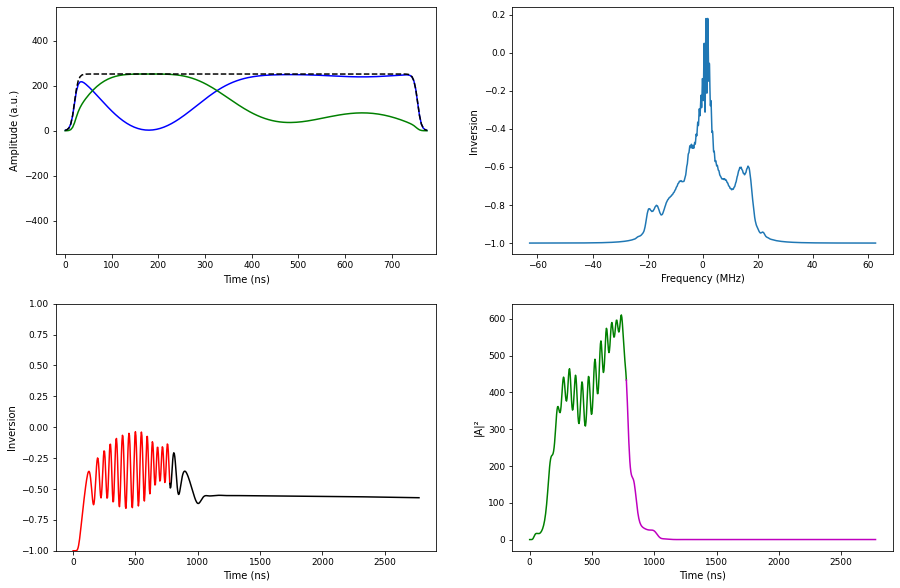

basinhopping step 0: f 1.09064
basinhopping step 1: f 1.09064 trial_f 1.13532 accepted 0  lowest_f 1.09064
basinhopping step 2: f 1.09064 trial_f 1.19196 accepted 0  lowest_f 1.09064
basinhopping step 3: f 1.09064 trial_f 1.76003 accepted 0  lowest_f 1.09064
basinhopping step 4: f 1.08155 trial_f 1.08155 accepted 1  lowest_f 1.08155
found new global minimum on step 4 with function value 1.08155
basinhopping step 5: f 1.08155 trial_f 1.2453 accepted 0  lowest_f 1.08155
basinhopping step 6: f 1.08155 trial_f 1.25491 accepted 0  lowest_f 1.08155
basinhopping step 7: f 1.08155 trial_f 1.73007 accepted 0  lowest_f 1.08155
basinhopping step 8: f 0.834689 trial_f 0.834689 accepted 1  lowest_f 0.834689
found new global minimum on step 8 with function value 0.834689
basinhopping step 9: f 0.834689 trial_f 1.03427 accepted 0  lowest_f 0.834689
basinhopping step 10: f 0.834689 trial_f 1.09257 accepted 0  lowest_f 0.834689
basinhopping step 11: f 0.834689 trial_f 1.19891 accepted 0  lowest_f 0.834

In [ ]:
gg = BasinHopping()
gg.number_fcp = 1
#init = array([ 142.49161423, -108.42653027,   0, 0, 63.06377972])
#init = array([  1.68325148,  77.52548987,  -0.22800116,  18.95515465, -73.91778102,
# -40.24173738,  47.46180413,  66.71024046, 206.9681236 ])
init = [ -8.1301843 , -87.71575796 ,152.61138485]
init = None
for nfcp in range(6):
    res = gg.main(init)
    print("Finished %s step"%nfcp)
    print(res.x)
    init = [*res.x[:-1],0, res.x[-2]/gg.scale_factor, res.x[-1]/gg.scale_factor]
    gg.number_fcp += 1

In [ ]:
%qtconsole
